# Swish-based ensemble with categorical entity embedding
- SWish activation, 4 layers, 100 neurons per layer
- PRI_jet_num embedded
- Train-time/test-time data augmentation
- SWA
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [ ]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
from __future__ import division
import sys
import os
sys.path.append('../../')
from modules.basics import *

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
NAME = '9_swish_ensemble_embed_aug_swaconst'

In [3]:
experiment = Experiment(NAME, 'helios_cuda', RESULTS_PATH)

In [4]:
!python ../../modules/data_import.py -d ../../data/ -f PRI_jet_num -s {experiment.seed}

/home/giles/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Converting to use_cartesian coordinates
Converting to use_cartesian coordinates
Training on 200000 datapoints and validating on 50000, using 31 feats:
['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_sub

## Training

### Import data

In [5]:
train_fy = HEPAugFoldYielder(DATA_PATH/'train.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [6]:
train_feats = train_fy.cont_feats+train_fy.cat_feats

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


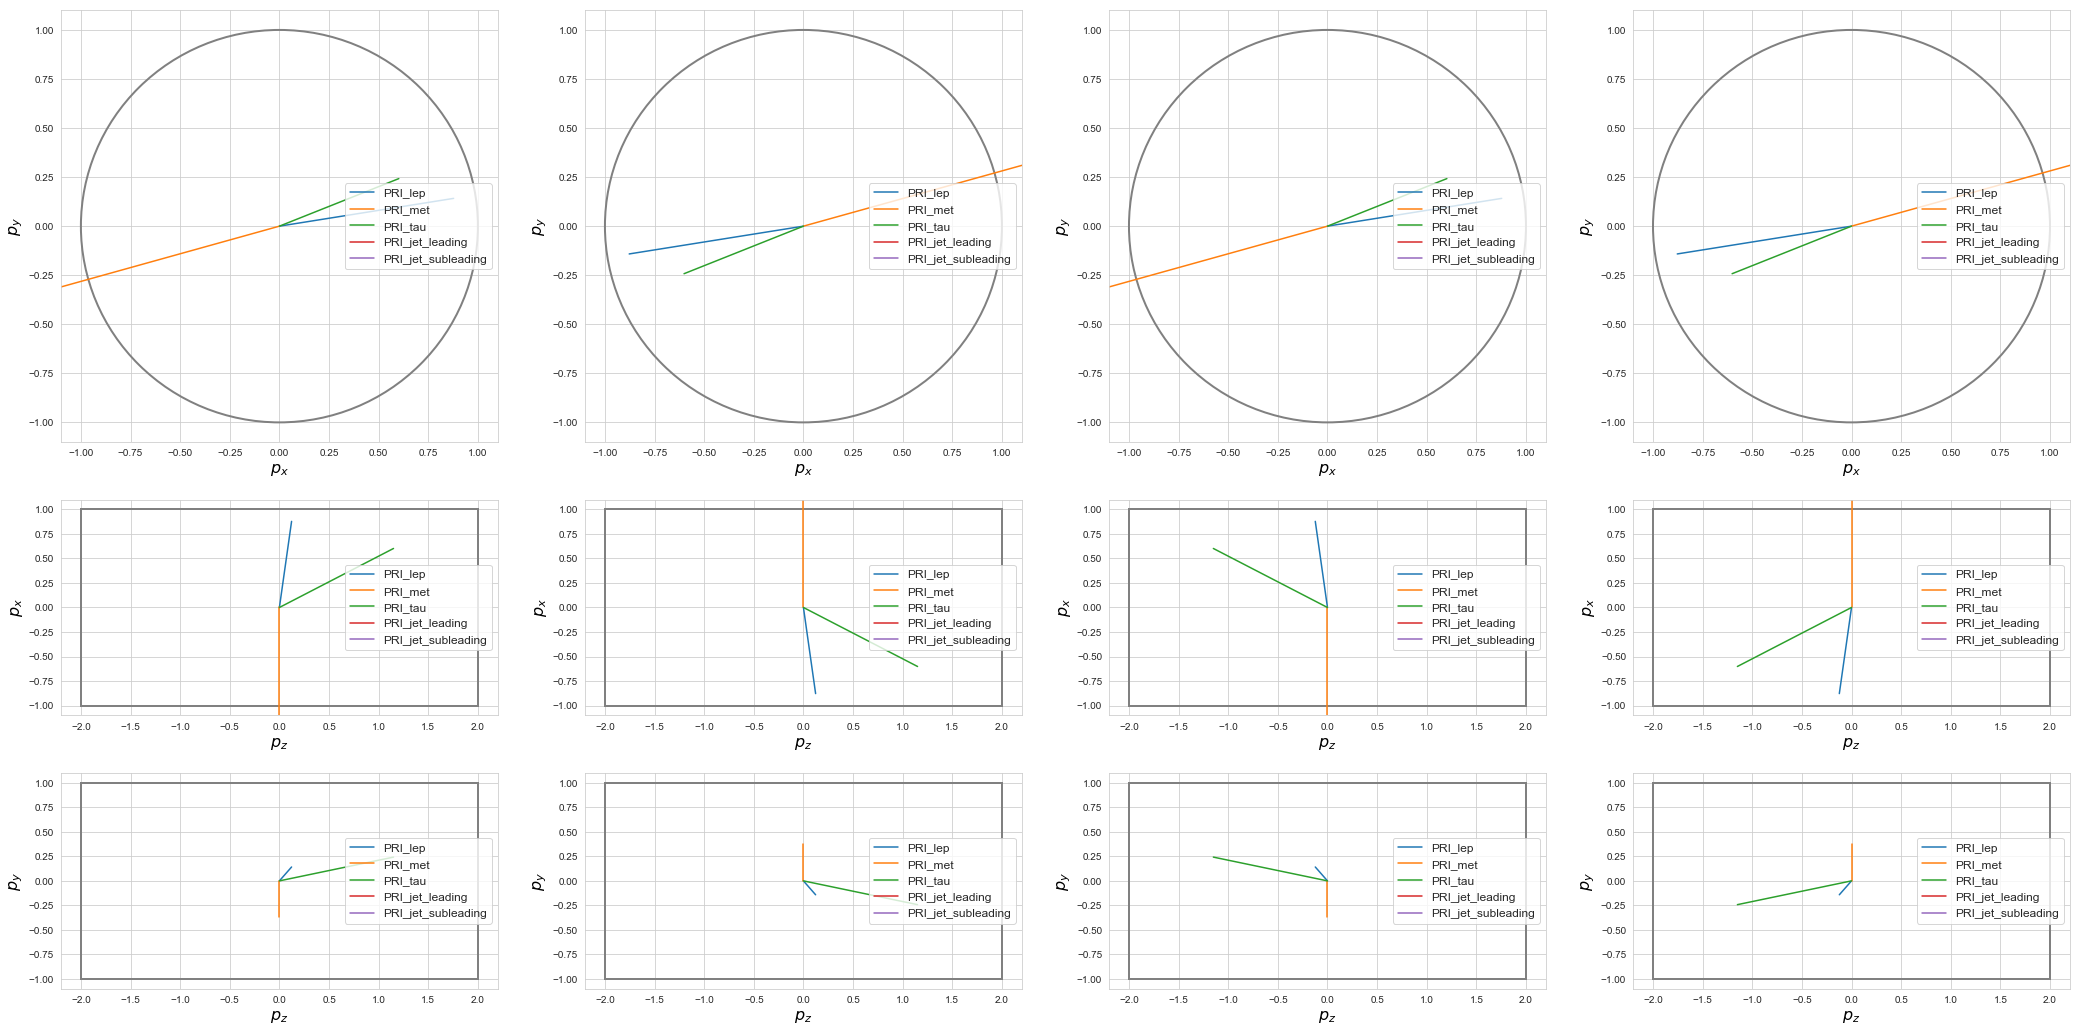

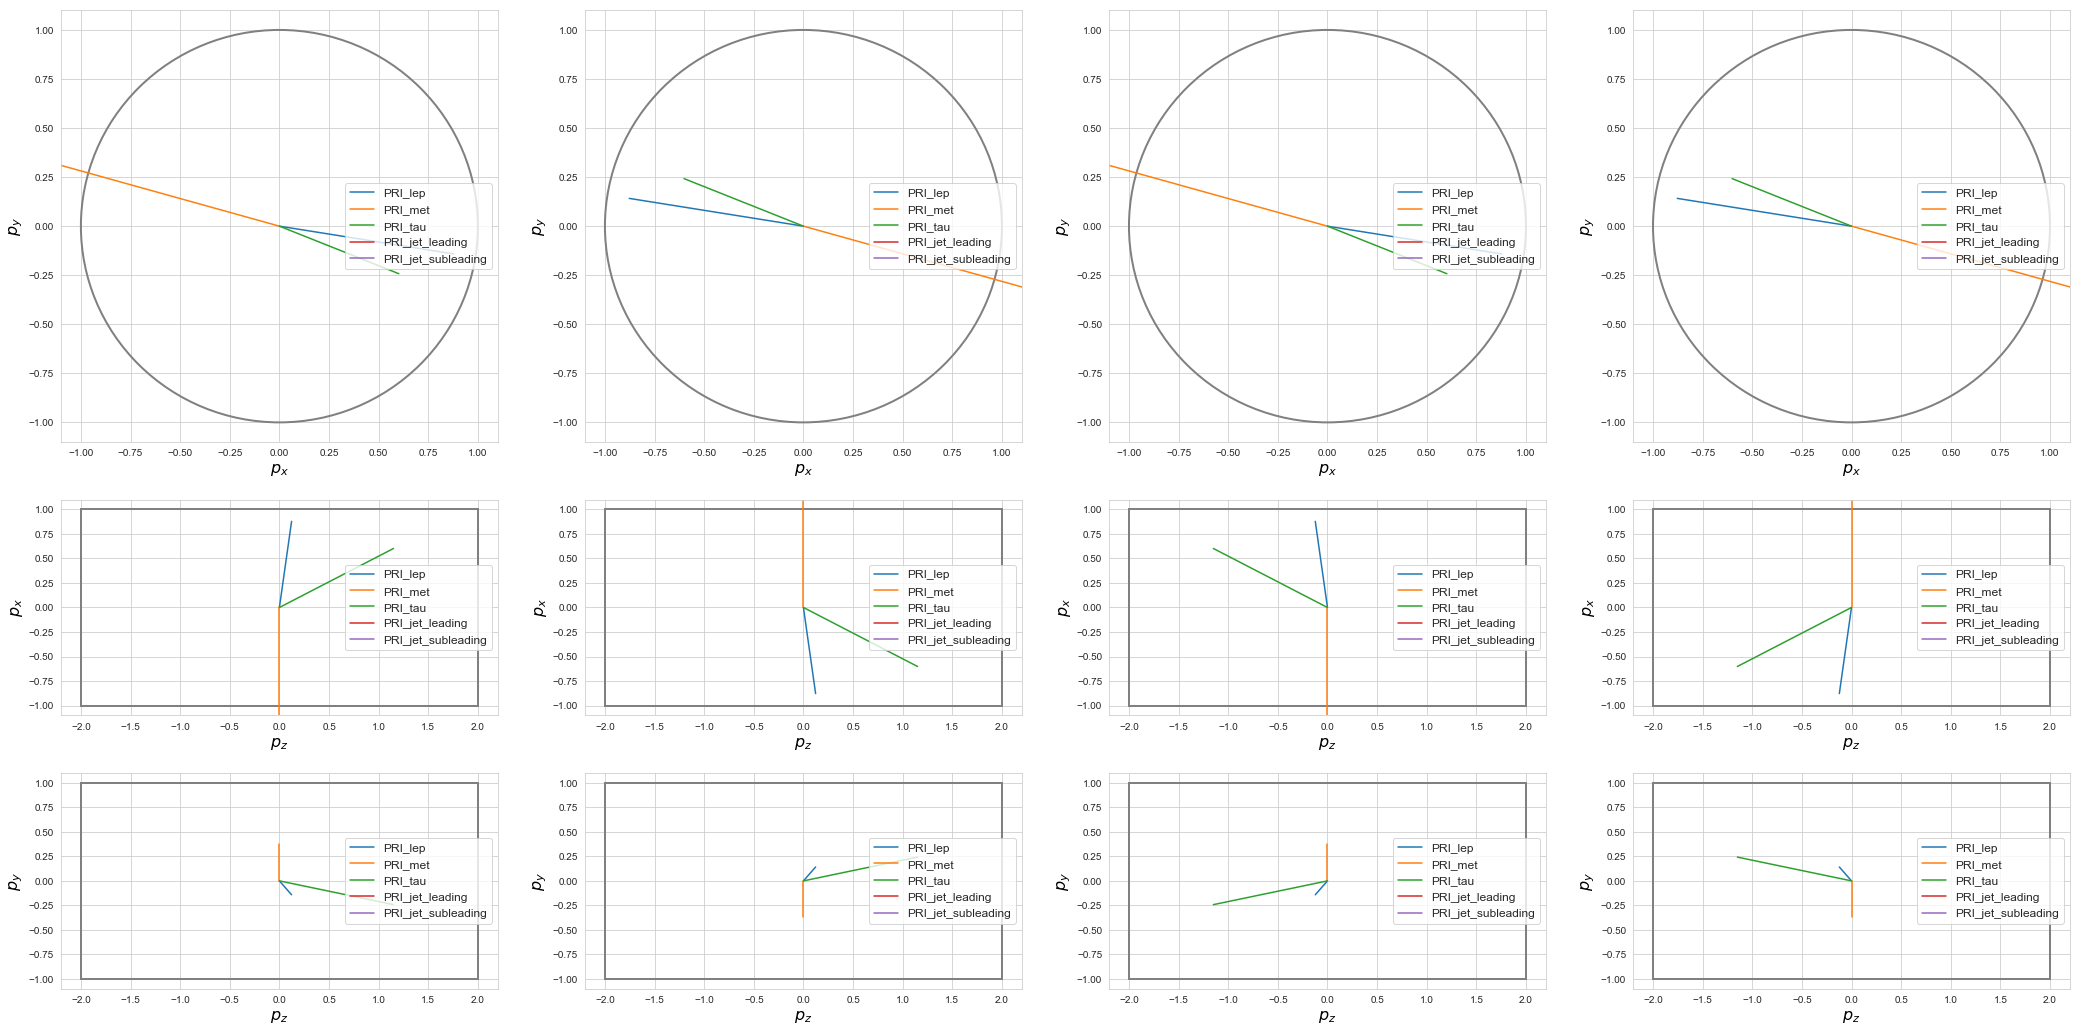

In [7]:
id=3
aug_ranges = [range(4), range(4,8)]
for aug_range in aug_ranges:
    compare_events([pd.DataFrame(train_fy.get_test_fold(0, i)['inputs'], columns=train_feats)[id:id+1] for i in aug_range])

/home/giles/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


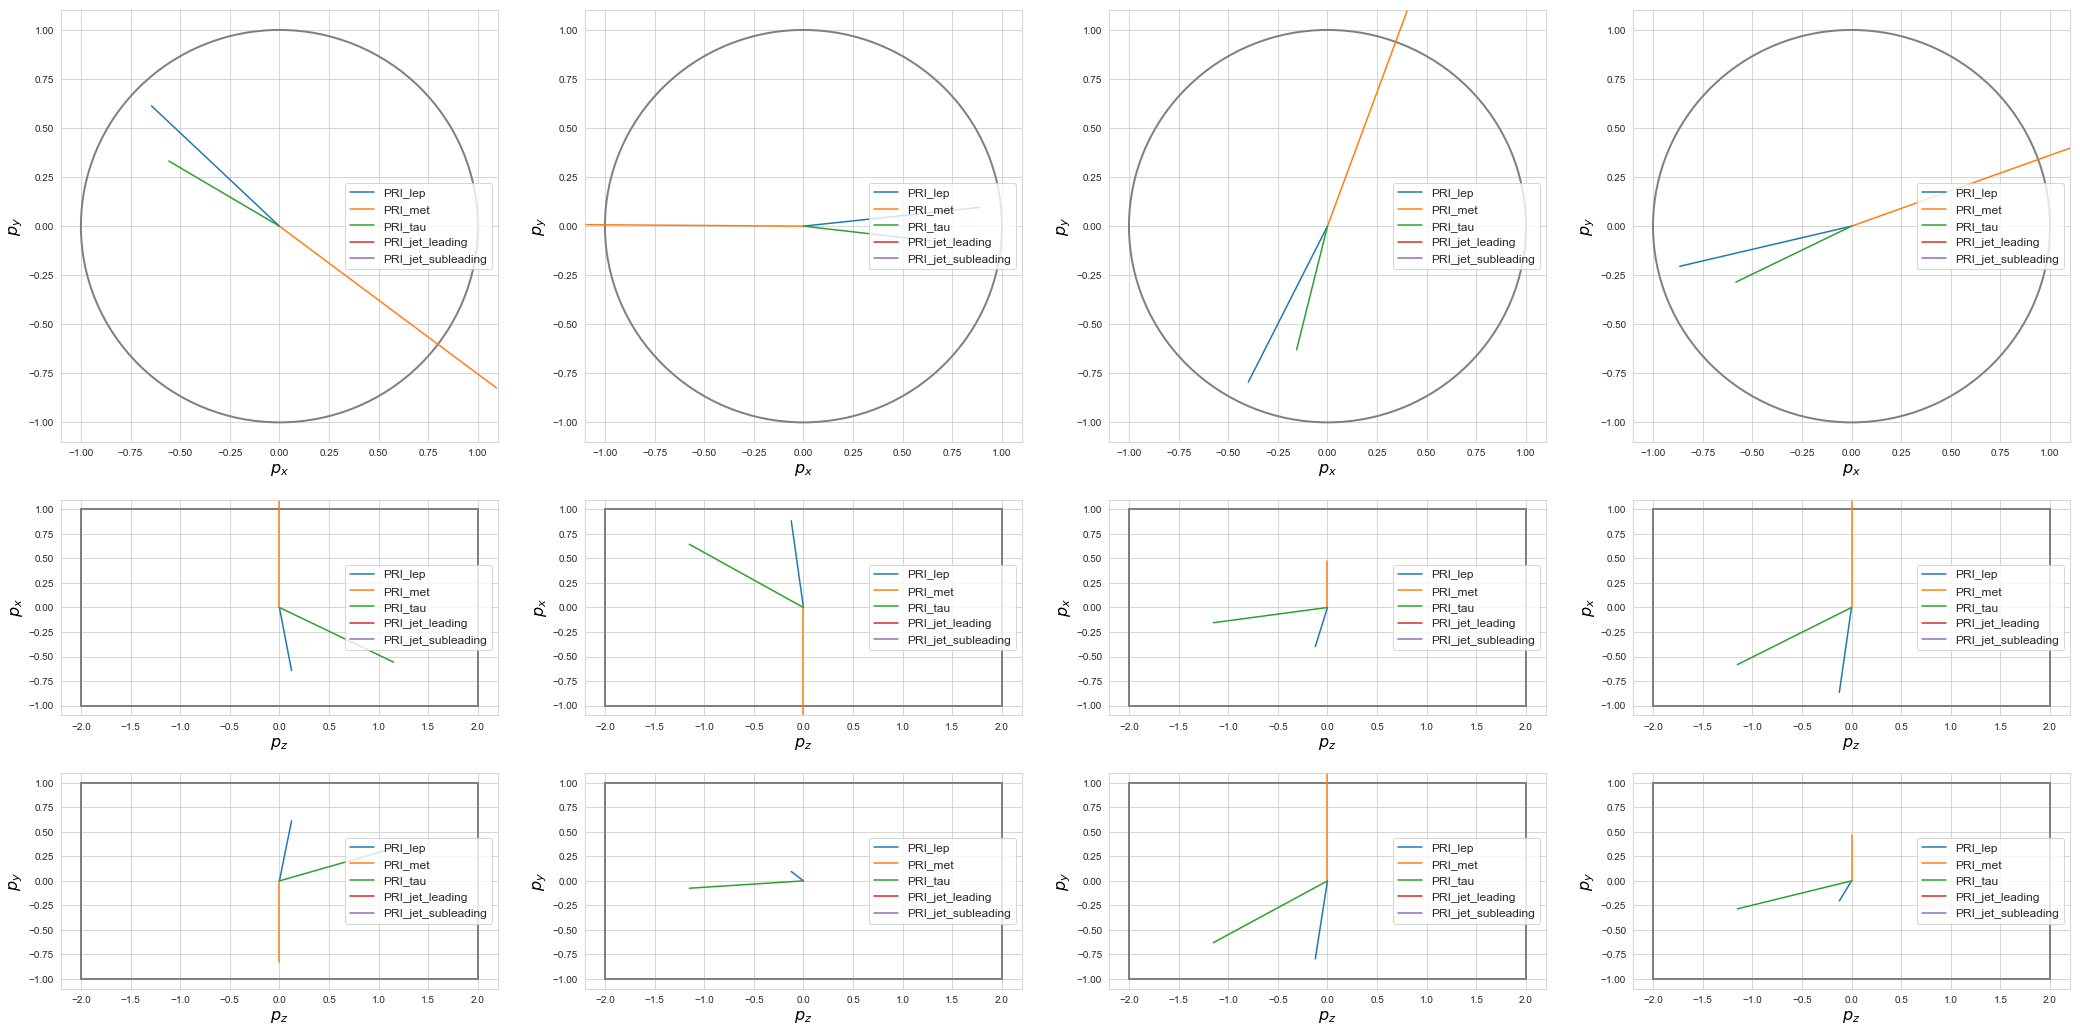

In [8]:
id=3
compare_events([pd.DataFrame(train_fy.get_fold(0)['inputs'], columns=train_feats)[id:id+1] for i in range(4)])

### Options

In [9]:
n_models = 10
patience = 50
max_epochs = 200
ensemble_size = 10

bs = 256
objective = 'classification'
model_args = {'body':{'act':'swish', 'width':100, 'depth':4}}
opt_args = {'opt':'adam', 'eps':1e-08}
cat_embedder = CatEmbedder.from_fy(train_fy, emb_szs=[3])

n_out = 1
model_builder = ModelBuilder(objective, cont_feats=train_fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder,
                             model_args=model_args, opt_args=opt_args)
Model(model_builder)

Inputs:
30 Continuous: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_sumet', 'PRI_jet_all_pt', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_met_px', 'PRI_met_py', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_pt']
                   
1  Categorical: ['PRI_jet_num']
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead(
    (embeds): ModuleList(
      (0): Embedding(4, 3)
    )
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=33, out_features=100, bias=True)
        (1): Swis

### Determine LR

LR finder took 3.872s 


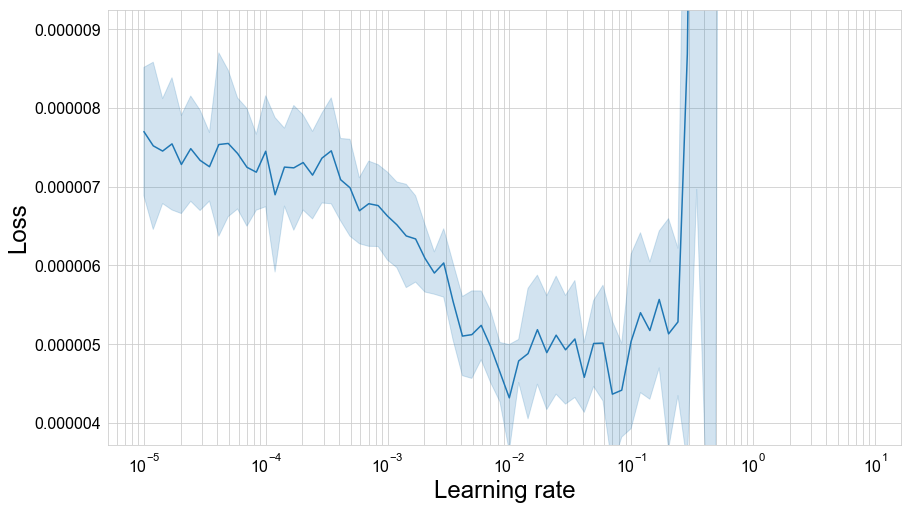

In [10]:
lr_finder = fold_lr_find(train_fy, model_builder, 256, lr_bounds=[1e-5,1e1])

### Train classifier

In [11]:
callback_partials = [partial(SWA, start_epoch=5, renewal_period=5, verbose=False)]
eval_metrics = {'AMS':AMS(n_total=250000, br=10, wgt_name='gen_weight_original')}

Training model 1 / 10, Val ID = 0


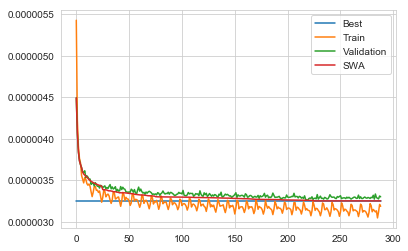

Early stopping after 289 epochs
Scores are: {'loss': 3.25093901665241e-06, 'AMS': 3.8048428956003657}
Fold took 125.677s

Training model 2 / 10, Val ID = 1


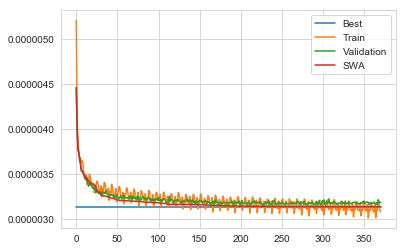

Early stopping after 371 epochs
Scores are: {'loss': 3.133612153760623e-06, 'AMS': 3.9801626435550377}
Fold took 161.173s

Training model 3 / 10, Val ID = 2


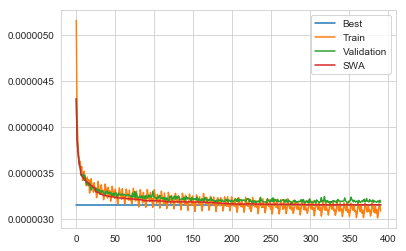

Early stopping after 391 epochs
Scores are: {'loss': 3.1543634122499498e-06, 'AMS': 4.329732497882978}
Fold took 170.217s

Training model 4 / 10, Val ID = 3


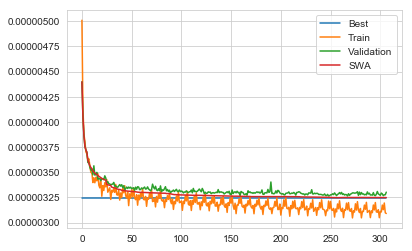

Early stopping after 307 epochs
Scores are: {'loss': 3.2474370073032333e-06, 'AMS': 3.770128846680037}
Fold took 137.008s

Training model 5 / 10, Val ID = 4


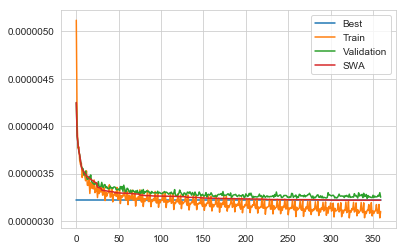

Early stopping after 360 epochs
Scores are: {'loss': 3.2204502531385515e-06, 'AMS': 3.80266894115517}
Fold took 158.963s

Training model 6 / 10, Val ID = 5


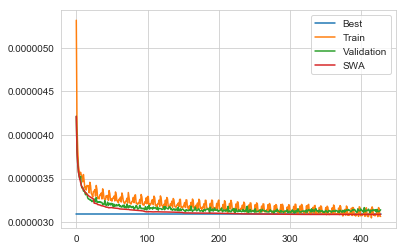

Early stopping after 428 epochs
Scores are: {'loss': 3.0883877570886398e-06, 'AMS': 4.007599180662751}
Fold took 186.404s

Training model 7 / 10, Val ID = 6


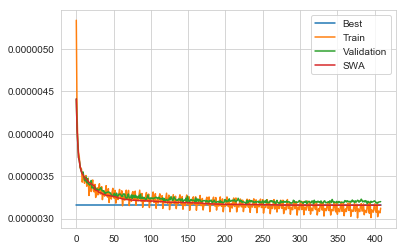

Early stopping after 409 epochs
Scores are: {'loss': 3.1574945751344785e-06, 'AMS': 3.555228478462706}
Fold took 178.111s

Training model 8 / 10, Val ID = 7


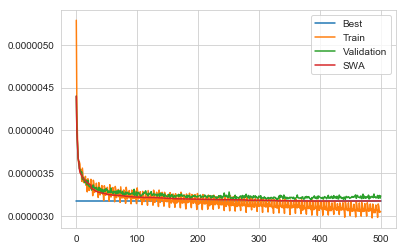

Early stopping after 501 epochs
Scores are: {'loss': 3.172186325173243e-06, 'AMS': 3.98671375352718}
Fold took 218.127s

Training model 9 / 10, Val ID = 8


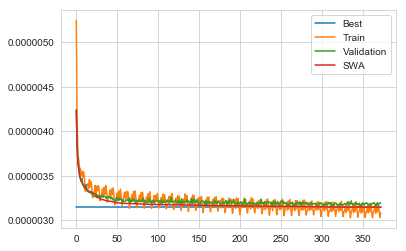

Early stopping after 373 epochs
Scores are: {'loss': 3.148012183373794e-06, 'AMS': 4.037763504628307}
Fold took 162.819s

Training model 10 / 10, Val ID = 9


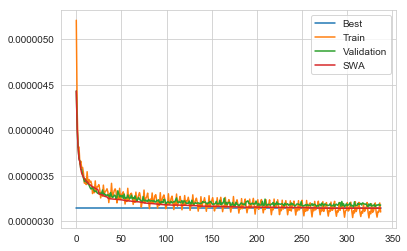

Early stopping after 338 epochs
Scores are: {'loss': 3.1444774322153535e-06, 'AMS': 4.232860212490876}
Fold took 147.602s


______________________________________
Training finished
Cross-validation took 1646.104s 


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

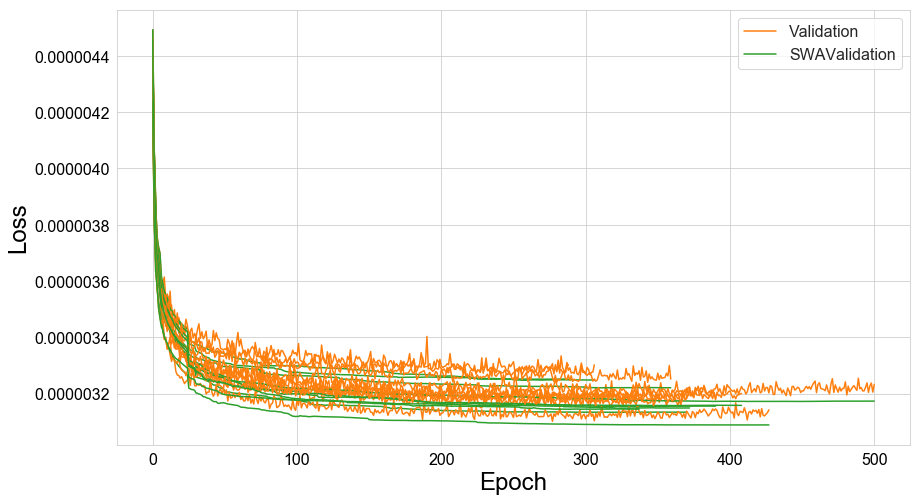

Mean loss = 3.17e-06±2e-08
Mean AMS = 3.95±0.07
______________________________________



In [12]:
train_timer = timeit.default_timer()
results, histories, cycle_losses = fold_train_ensemble(train_fy, n_models,
                                                       model_builder=model_builder,
                                                       bs=bs,
                                                       callback_partials=callback_partials,
                                                       eval_metrics=eval_metrics,
                                                       max_epochs=max_epochs, patience=patience)
train_time = timeit.default_timer()-train_timer
experiment['train_time'] = train_time

## Inference

### Construct ensemble

In [13]:
with open('train_weights/results_file.pkl', 'rb') as fin:   
    results = pickle.load(fin)
with open('train_weights/cycle_file.pkl', 'rb') as fin:   
    cycle_losses = pickle.load(fin)

In [14]:
ensemble = Ensemble.from_results(results, ensemble_size, model_builder, metric='loss', higher_metric_better=False)

Choosing ensemble by loss


Model 0 is 5 with loss = 3.0883877570886398e-06
Model 1 is 1 with loss = 3.133612153760623e-06
Model 2 is 9 with loss = 3.1444774322153535e-06
Model 3 is 8 with loss = 3.148012183373794e-06
Model 4 is 2 with loss = 3.1543634122499498e-06
Model 5 is 6 with loss = 3.1574945751344785e-06
Model 6 is 7 with loss = 3.172186325173243e-06
Model 7 is 4 with loss = 3.2204502531385515e-06
Model 8 is 3 with loss = 3.2474370073032333e-06
Model 9 is 0 with loss = 3.25093901665241e-06


### Validation

#### Response on validation data without TTA

In [15]:
val_fy = FoldYielder(DATA_PATH/'val.hdf5')

In [16]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy)
val_time = timeit.default_timer()-val_timer
experiment['val_time_no_tta'] = val_time

Mean time per event = 2.37e-06±4e-08


In [17]:
val_df = val_fy.get_df()

50000 datapoints loaded


Mean cut at 0.9464288353919983 corresponds to AMS of 3.6899241405285994
Maximum AMS for data is 3.759180494931164 at cut of 0.953334391117096


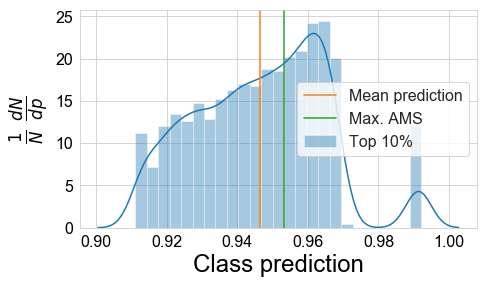

In [18]:
cut, experiment['val_ams_smooth_no_tta'], experiment['val_ams_max_no_tta'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

#### Response on validation data with TTA

In [19]:
val_fy = HEPAugFoldYielder(DATA_PATH/'val.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [20]:
val_timer = timeit.default_timer()
ensemble.predict(val_fy, pred_name='pred_tta')
val_time = timeit.default_timer()-val_timer
experiment['val_time'] = val_time

Mean time per event = 8.15e-05±1e-07


In [21]:
val_df = val_fy.get_df(pred_name='pred_tta')

50000 datapoints loaded


Mean cut at 0.9449491500854492 corresponds to AMS of 3.7399669940627214
Maximum AMS for data is 3.7635853245766007 at cut of 0.9428663849830627


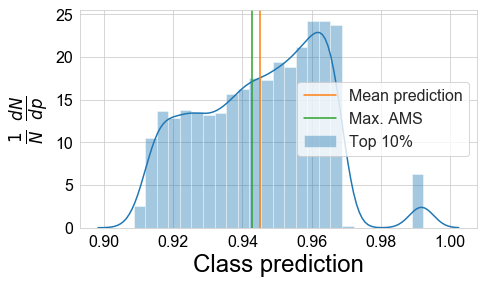

In [22]:
cut_tta, experiment['val_ams_smooth'], experiment['val_ams_max'] = binary_class_cut_by_ams(val_df, top_perc=10, br=10, wgt_factor=250000/50000)

### Testing

#### Test scoring without TTA

In [23]:
test_fy = FoldYielder(DATA_PATH/'test.hdf5')

In [24]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy)
test_time = timeit.default_timer()-test_timer
experiment['test_time_no_tta'] = test_time

Mean time per event = 9.8e-07±2e-08


In [25]:
experiment['test_public_ams_mean_no_tta'], experiment['test_private_ams_mean_no_tta'] = score_test_data_per_fold(test_fy, cut, pred_name='pred')

Mean Public:Private AMS: 3.76±0.05 : 3.8±0.02


In [26]:
experiment['test_public_ams_no_tta'], experiment['test_private_ams_no_tta'] = score_test_data(test_fy, cut, pred_name='pred')

Public:Private AMS: 3.761945841866894 : 3.8019317769606595


#### Test scoring with TTA

In [27]:
test_fy = HEPAugFoldYielder(DATA_PATH/'test.hdf5', rot_mult=2)

Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [28]:
test_timer = timeit.default_timer()
ensemble.predict(test_fy, pred_name='pred_tta')
test_time = timeit.default_timer()-test_timer
experiment['test_time'] = test_time

Mean time per event = 3.394e-05±6e-08


In [29]:
experiment['test_public_ams_mean'], experiment['test_private_ams_mean'] = score_test_data_per_fold(test_fy, cut_tta, pred_name='pred_tta')

Mean Public:Private AMS: 3.8±0.05 : 3.8±0.03


In [30]:
experiment['test_public_ams'], experiment['test_private_ams'] = score_test_data(test_fy, cut_tta, pred_name='pred_tta')

Public:Private AMS: 3.792327777921635 : 3.7972107240456032


## Results 

In [31]:
experiment

Experiment:	9_swish_ensemble_embed_aug_swaconst
Machine:	helios_cuda
Device:	Nvidia GeForce GTX 1080 Ti GPU
train_time	1646.5413266729993
val_time_no_tta	0.12606047299959755
val_ams_smooth_no_tta	3.6899241405285994
val_ams_max_no_tta	3.759180494931164
val_time	4.0806004959995335
val_ams_smooth	3.7399669940627214
val_ams_max	3.7635853245766007
test_time_no_tta	0.5507354040000791
test_public_ams_mean_no_tta	(3.7648382273941463, 0.049705176439145904)
test_private_ams_mean_no_tta	(3.8040734450905136, 0.024687801736830956)
test_public_ams_no_tta	3.761945841866894
test_private_ams_no_tta	3.8019317769606595
test_time	18.681336640000154
test_public_ams_mean	(3.7961511364187857, 0.053946081178613804)
test_private_ams_mean	(3.800246243293363, 0.0307180115756515)
test_public_ams	3.792327777921635
test_private_ams	3.7972107240456032

In [32]:
experiment.save()